# Image Classification

In [2]:
from fastai.vision.all import *

In [3]:
#Download data of dogs and cats
path = untar_data(URLs.PETS)
path.ls()

(#2) [Path('C:/Users/joaqu/.fastai/data/oxford-iiit-pet/annotations'),Path('C:/Users/joaqu/.fastai/data/oxford-iiit-pet/images')]

In [4]:
#Get the name
fname = (path/"images").ls()[0]
re.findall(r'(.+)_\d+.jpg$', fname.name)

['Abyssinian']

In [5]:
#Create dataloaders
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items = get_image_files,
                 splitter = RandomSplitter(seed=42),
                 get_y = using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms = Resize(460),
                 batch_tfms = aug_transforms(size=224, min_scale=0.75)
                 )

dls =  pets.dataloaders(path/"images")

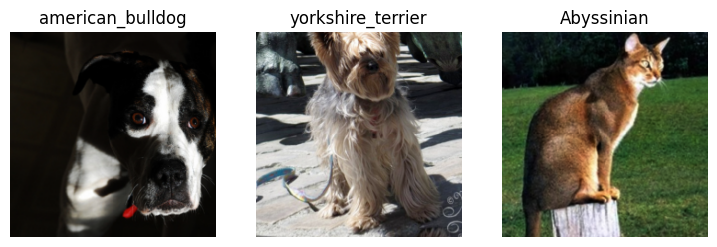

In [6]:
#Check if dataloaders is working
dls.show_batch(nrows=1, ncols=3)

In [7]:
#Initial test with a resnet34 arquitecture
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

c:\Users\joaqu\anaconda3\envs\pytorch_env\Lib\site-packages\fastai\vision\learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\joaqu/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 49.8MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.558001,0.304700,0.099459,02:26


epoch,train_loss,valid_loss,error_rate,time
0,0.514166,0.319724,0.104871,01:32
1,0.330152,0.213849,0.064953,01:31


In [8]:
#Viewing Activations and Labels
x, y = dls.one_batch()
y

TensorCategory([27, 10, 19,  2,  4,  7, 22,  2, 15,  3, 20, 24, 15, 11, 10, 14,
                12, 20, 19, 35, 14,  1,  1, 20, 21,  1, 28, 16, 18, 21, 34, 29,
                18, 12,  4,  8, 32, 17, 11, 33, 15, 27, 18, 36, 11, 11, 14, 31,
                 7, 21, 26, 24, 20, 34, 28, 24,  4, 20, 30, 32, 12, 19, 22,  4],
               device='cuda:0')

In [11]:
# See predictions of 1 image
preds, _ = learn.get_preds(dl = [(x,y)])
print(preds[0])
len(preds[0]),preds[0].sum()

tensor([2.9838e-08, 5.3882e-08, 1.2056e-07, 1.0560e-06, 7.0256e-06, 8.4763e-07,
        1.4495e-07, 3.4192e-07, 1.7644e-08, 9.0231e-07, 2.7422e-07, 7.2132e-08,
        3.0429e-06, 1.0254e-05, 3.1418e-06, 6.0832e-08, 1.1532e-07, 3.8371e-07,
        3.6947e-06, 3.8521e-07, 1.2785e-04, 2.1130e-04, 1.1972e-06, 2.5858e-06,
        3.7905e-06, 2.9470e-04, 8.5539e-07, 9.9929e-01, 3.8107e-07, 9.0203e-06,
        1.8659e-05, 2.9117e-07, 3.6533e-06, 1.4400e-07, 5.8625e-07, 7.7640e-07,
        1.0769e-07])


(37, tensor(1.0000))

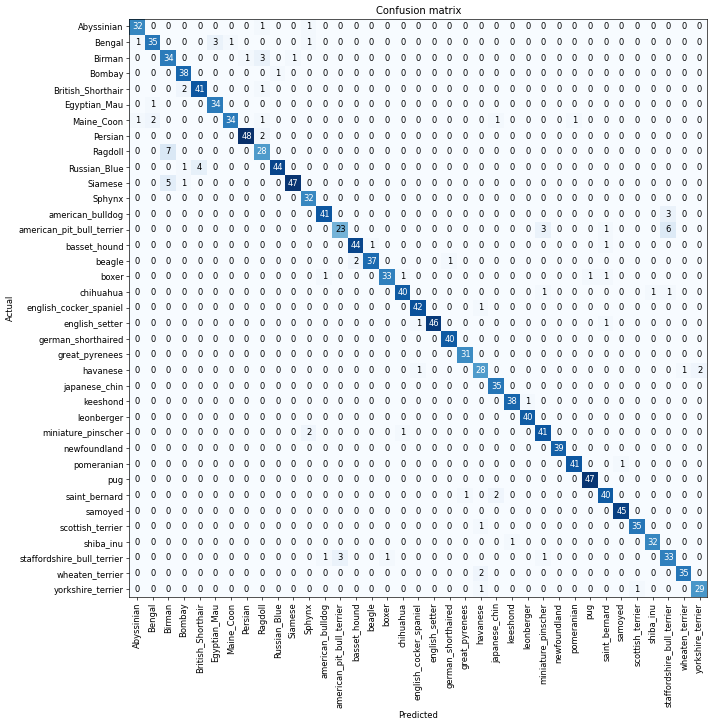

In [12]:
#Model Interpretation
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize =(12,12), dpi=60)

In [13]:
interp.most_confused(min_val=5)

[('Ragdoll', 'Birman', 7),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Siamese', 'Birman', 5)]

SuggestedLRs(valley=0.0006918309954926372)

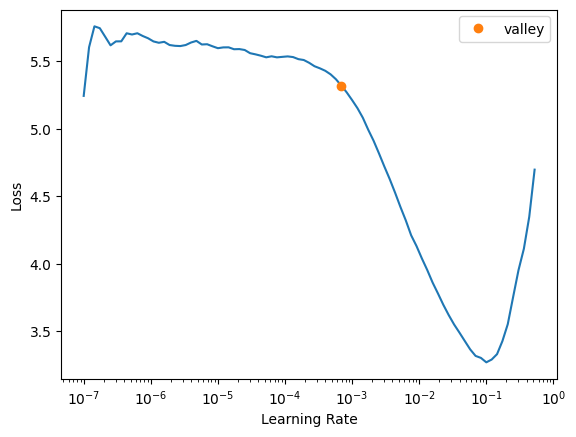

In [16]:
#Learning Rate Finder
learn = cnn_learner(dls, resnet34, metrics = error_rate)
learn.lr_find()


In [17]:
#Unfreezing and Transfer Learning
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 7e-4)

c:\Users\joaqu\anaconda3\envs\pytorch_env\Lib\site-packages\fastai\vision\learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,1.991467,0.384090,0.112991,01:23
1,0.774715,0.265823,0.085250,01:22
2,0.517063,0.250404,0.079161,01:25


SuggestedLRs(valley=2.511886486900039e-05)

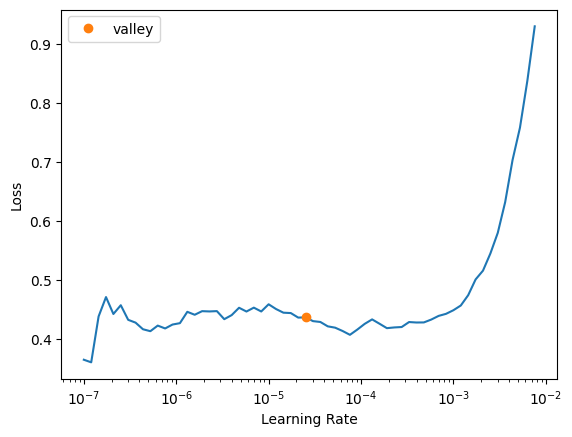

In [19]:
learn.unfreeze()
learn.lr_find()

In [20]:
# train at a suitable learning rate
learn.fit_one_cycle(6, lr_max=25e-6)

epoch,train_loss,valid_loss,error_rate,time
0,0.407563,0.233026,0.075778,01:32
1,0.386753,0.212226,0.071719,01:28
2,0.317450,0.198552,0.062923,01:29
3,0.275358,0.194265,0.062923,01:30
4,0.253099,0.184717,0.063599,01:30
5,0.225206,0.186706,0.061570,01:30


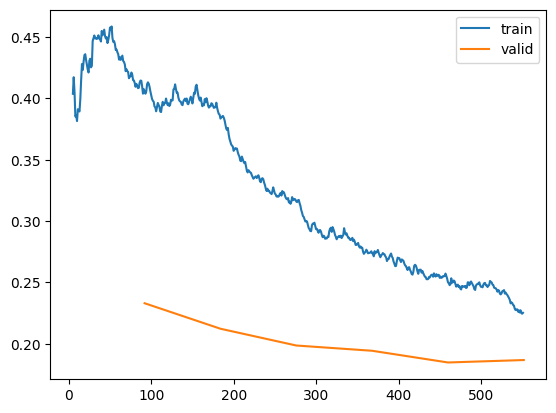

In [21]:
# Show a graph of the training and validation loss:
learn.recorder.plot_loss()